In [1]:
library(dplyr)
library(class)
library(tidyverse)
library(pROC)
library(glmnet)

#install.packages('glmnetUtils')
library(glmnetUtils)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ──────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ readr   1.3.1
✔ tibble  3.1.4     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ ggplot2 3.1.1     ✔ forcats 0.4.0
── Conflicts ─────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: Matrix

Attaching 

In [3]:
data <- readRDS("../data/ATAC_predictions_train_20_predict_80/ATAC_pred_lasso_normalized_trimmed_formatted_standardized.rds")
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

,sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_39,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399
V1,PGDX16568P,0.7621097,-0.8032188,0.6402487,-0.8688929,-0.4792134,-0.5096581,0.02594817,0.7295906,0.7738027,...,-0.405123632,0.59187320,-0.29125018,-0.58276010,0.3792968,-0.04366948,0.9183014,0.7664238,0.9980457,-1.0572778
V2,PGDX16569P,0.7057109,-0.8227554,0.7868749,-1.0407754,-0.9284673,-0.4139074,-0.16594560,0.7765621,0.5761691,...,-0.849313481,0.39431325,0.05197526,-0.36318168,0.1744439,-0.13785162,0.5392077,0.3942941,1.7972449,-0.3619464
V3,PGDX16570P,0.4891340,-1.1448217,0.9478602,-1.0930696,-0.5115270,-0.7552269,-0.48824613,0.9537215,0.6624865,...,-0.871941533,-0.06389996,-0.22907645,-0.32470631,-0.6251958,0.17051719,0.6882020,0.1744819,1.4357406,-0.2330366
V4,PGDX16571P,0.6882727,-0.8585679,0.6248431,-0.8310281,-0.5335804,-0.5125528,-0.34185944,0.9281618,0.4768828,...,-0.005893625,0.18185487,0.32387927,0.04577069,0.2752394,0.22750427,0.6333635,0.8413436,1.2819797,0.5629469
V5,PGDX16579P,0.5801896,-1.1674832,0.7883376,-1.0498406,-1.2475692,-0.7345196,-0.18778863,0.2546093,0.2920616,...,-0.067895629,-0.05197828,-0.18308631,-0.70242368,-0.4281903,-0.06235782,1.0764914,1.1411410,0.8795170,-0.4910720
V6,PGDX16580P,0.6831409,-0.8712906,0.7199476,-1.1853489,-0.8520159,-0.6829992,-0.35499242,0.8598551,0.3870744,...,-0.735310376,0.36325245,0.20814984,-0.50307962,0.2609116,0.53933999,1.0772367,0.6906960,1.7696570,-0.4181884


In [4]:
#sample_types <- read.table(snakemake@input[["input_sample_types"]], header = F, sep = " ")
sample_types <- read.table("../data/sample_types.txt", header = F, sep = " ")

colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [7]:
data <- merge(data, sample_types, by="sample")
data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type,sample_type01
PGDX10344P1,0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,...,0.006860094,-0.5010935,-0.2043651,0.02437101,0.57938365,-0.4136060,1.3160044,-0.26256223,Gastric_cancer,1
PGDX10346P1,1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,...,-0.421600296,-0.5810840,0.1408379,0.21122926,1.13429106,0.8116547,0.3187471,-0.48265821,Gastric_cancer,1
PGDX10349P1,0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,...,0.527804492,-0.1435833,0.4967880,0.15991730,0.89522351,0.5305742,1.6767953,-0.02839009,Gastric_cancer,1
PGDX10351P1,1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,...,0.872833915,-0.0670184,0.7394425,0.13690205,1.29732717,0.4739056,1.4153912,-0.12217374,Gastric_cancer,1
PGDX10566P,0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,...,0.173364771,-0.8705736,0.4935296,-0.17648798,-0.02395699,0.3182328,1.3930824,-0.47078676,Ovarian_Cancer,1
PGDX10567P,0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,...,-0.241967372,-0.6951369,0.2412607,0.11914801,0.07982386,0.2854560,1.7946488,-0.69550001,Ovarian_Cancer,1


In [8]:
data <- data %>% select(-sample_type)

In [9]:
data <- data %>% select(-sample)
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,chr10_407,...,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type01
0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,1.45146500,...,-0.34089350,0.006860094,-0.5010935,-0.2043651,0.02437101,0.57938365,-0.4136060,1.3160044,-0.26256223,1
1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,0.04814456,...,-0.17629217,-0.421600296,-0.5810840,0.1408379,0.21122926,1.13429106,0.8116547,0.3187471,-0.48265821,1
0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,1.33462998,...,1.22409122,0.527804492,-0.1435833,0.4967880,0.15991730,0.89522351,0.5305742,1.6767953,-0.02839009,1
1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,0.97671516,...,0.43571295,0.872833915,-0.0670184,0.7394425,0.13690205,1.29732717,0.4739056,1.4153912,-0.12217374,1
0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,0.76308429,...,0.04951928,0.173364771,-0.8705736,0.4935296,-0.17648798,-0.02395699,0.3182328,1.3930824,-0.47078676,1
0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,0.64706533,...,0.50968208,-0.241967372,-0.6951369,0.2412607,0.11914801,0.07982386,0.2854560,1.7946488,-0.69550001,1


In [18]:
get_model_params <- function(fit) {
  alpha <- fit$alpha
  lambdaMin <- sapply(fit$modlist, `[[`, "lambda.min")
  lambdaSE <- sapply(fit$modlist, `[[`, "lambda.1se")
  error <- sapply(fit$modlist, function(mod) {min(mod$cvm)})
  best <- which.min(error)
  data.frame(alpha = alpha[best], lambdaMin = lambdaMin[best],
             lambdaSE = lambdaSE[best], error = error[best])
}

nested_CV_lasso <- function(data, k_inner_cv, k_outer_cv){
    
    y <- data %>% dplyr::select(sample_type01) %>%  as.matrix()
    X <- data %>% dplyr::select(-sample_type01) %>% as.matrix() 
    observed <- y
    return_tibble <- tibble(observed = observed)
    
    for (i in 1:k_outer_cv){ # repeated Cross-validation loop
    
        set.seed(i)
        cvfolds <- cut(1:nrow(data), breaks = k_inner_cv, labels = F)
        cvfolds <- sample(cvfolds)

        predicted <- rep(NA, nrow(data))

        for (n in 1:k_inner_cv){
            rows      <- which(cvfolds==n)
            testdata  <- X[rows,]
            traindata <- X[-rows,]
            train_y <- y[-rows,]

            ########### nested CV to find best alpha and lambda on train folds ###########
            set.seed(0) # alpha
            lasso_cva <- cva.glmnet(traindata, train_y, nfolds = 10)
            best_params <- get_model_params(lasso_cva)
            best_alpha <- best_params$alpha
            best_lambda_min <- best_params$lambdaMin 
            best_lambda_se <- best_params$lambdaSE 
            
            message("best_alpha")
            message(best_alpha)
            message("best_lambda_min")
            message(best_lambda_min)
            ####################################################################

            fit       <- glmnet(traindata, train_y, family = "binomial", alpha = best_alpha, lambda = best_lambda_min)
            tmp       <- predict(fit, s=best_lambda_min, testdata, type = "response")
            message(head(tmp))
            predicted[rows] <- tmp
        }
        
    current_round_tibble <- tibble(predicted = predicted)
    return_tibble <- cbind(return_tibble, current_round_tibble)
    } # end of outer cv loop
    
    return(return_tibble)
}

In [19]:
results <- nested_CV_lasso(data, k_inner_cv = 2, k_outer_cv = 2)

best_alpha
0.125
best_lambda_min
0.125197679096208
0.5324278232021130.9784821200714340.6909981254349720.9992103754788090.8977068787206180.622848753474451
best_alpha
0.001
best_lambda_min
2.07598155691582
0.379910446798250.2210196367434260.3937940136662060.7491147924527090.9016026293989040.994895990361702
best_alpha
0
best_lambda_min
2.04351436859641
0.441409121453690.9064246265972650.5386104717358620.7086742230695620.5073855226097520.477994879553823
best_alpha
0
best_lambda_min
1.96416769462768
0.378812975378620.9950715891786680.2308787558953020.4423027597524190.8252513391384460.60868791172475


In [16]:
results <- tibble(results, .name_repair = "unique")
head(results)

observed,prob
1,0.4788580
1,0.3887053
1,0.9726746
1,0.2415177
1,0.5473564
1,0.8391385


In [ ]:
saveRDS(results, file = snakemake@output[["lasso_output"]])

In [18]:
rocs <- roc(observed ~ predicted...2 + 
                    predicted...3 + 
                    predicted...4 + 
                    predicted...5 + 
                    predicted...6 +
                    predicted...7 +
                    predicted...8 + 
                    predicted...9 + 
                    predicted...10 + 
                    predicted...11, data = results)
ggroc(rocs)

[1] 0.8778575

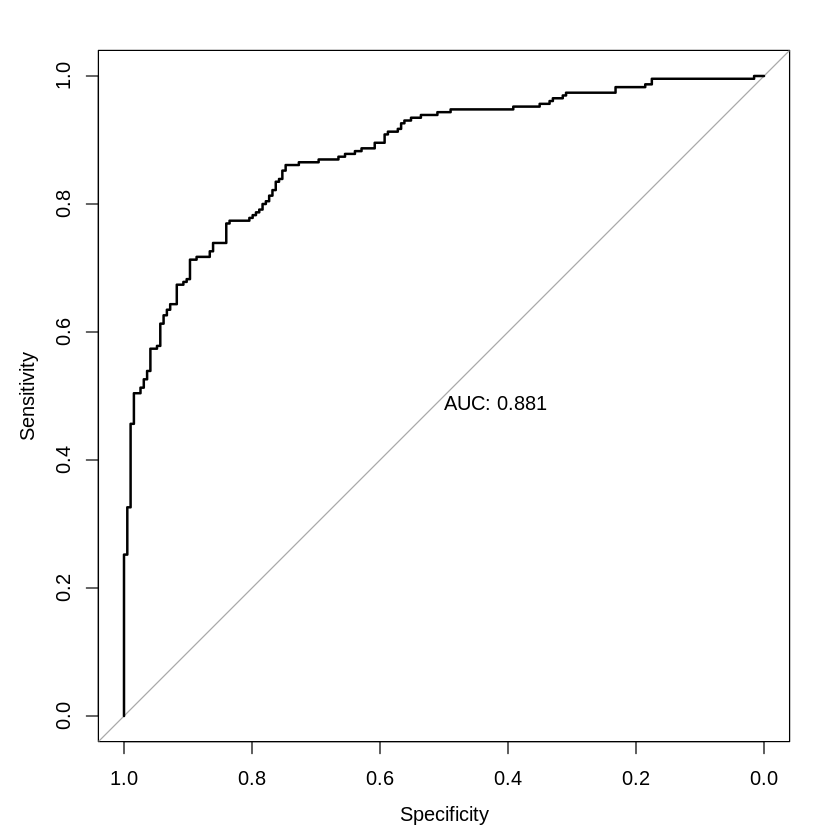

In [24]:
roc1 <- roc(results$observed, results$predicted...2)
roc2 <- roc(results$observed, results$predicted...3)
roc3 <- roc(results$observed, results$predicted...4)
roc4 <- roc(results$observed, results$predicted...5)
roc5 <- roc(results$observed, results$predicted...6)
roc6 <- roc(results$observed, results$predicted...7)
roc7 <- roc(results$observed, results$predicted...8)
roc8 <- roc(results$observed, results$predicted...9)
roc9 <- roc(results$observed, results$predicted...10)
roc10 <- roc(results$observed, results$predicted...11)

In [ ]:
paste("Mean AUC over 10 repetitions of 10-fold CV: ", mean(c(roc1$auc, roc2$auc, roc3$auc, roc4$auc, roc5$auc, roc6$auc, roc7$auc, roc8$auc, roc9$auc, roc10$auc)), sep = "")

In [98]:
results_01 <- results %>% mutate(predicted...2_01 = ifelse(predicted...2 > 0.5, 1, 0), 
                                 predicted...3_01 = ifelse(predicted...3 > 0.5, 1, 0), 
                                 predicted...4_01 = ifelse(predicted...4 > 0.5, 1, 0),
                                 predicted...5_01 = ifelse(predicted...5 > 0.5, 1, 0),
                                 predicted...6_01 = ifelse(predicted...6 > 0.5, 1, 0),
                                 predicted...7_01 = ifelse(predicted...7 > 0.5, 1, 0),
                                 predicted...8_01 = ifelse(predicted...8 > 0.5, 1, 0),
                                 predicted...9_01 = ifelse(predicted...9 > 0.5, 1, 0),
                                 predicted...10_01 = ifelse(predicted...10 > 0.5, 1, 0),
                                 predicted...11_01 = ifelse(predicted...11 > 0.5, 1, 0))

In [99]:
error_rates <- c(mean(results_01$observed != results_01$predicted...2_01),
               mean(results_01$observed != results_01$predicted...3_01), 
               mean(results_01$observed != results_01$predicted...4_01),
               mean(results_01$observed != results_01$predicted...5_01),
               mean(results_01$observed != results_01$predicted...6_01),
               mean(results_01$observed != results_01$predicted...7_01),
               mean(results_01$observed != results_01$predicted...8_01),
               mean(results_01$observed != results_01$predicted...9_01), 
               mean(results_01$observed != results_01$predicted...10_01), 
               mean(results_01$observed != results_01$predicted...11_01))

error_rates

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")

[1] 0.2853774

In [100]:
accuracies <- c(mean(results_01$observed == results_01$predicted...2_01),
               mean(results_01$observed == results_01$predicted...3_01), 
               mean(results_01$observed == results_01$predicted...4_01),
               mean(results_01$observed == results_01$predicted...5_01),
               mean(results_01$observed == results_01$predicted...6_01),
               mean(results_01$observed == results_01$predicted...7_01),
               mean(results_01$observed == results_01$predicted...8_01),
               mean(results_01$observed == results_01$predicted...9_01), 
               mean(results_01$observed == results_01$predicted...10_01), 
               mean(results_01$observed == results_01$predicted...11_01))

accuracies
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")

[1] 0.7146226